Sensitivity analysis.ipynb


# Data

In [1]:
import data_preparation
import custom_func
import model
import model_analysis

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Import data
spill_data = pd.read_excel('Inputs/data_100_oil_spills.xlsx', sheet_name='spills', header=0).copy()
current_station_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='current', header=0).copy()
current_input_param = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='current input param', header=0).copy()


potential_station_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()
potential_station_data = potential_station_data.iloc[[0, 4,7, 10, 11, 18]] # if we want to keep current facility setup in the set of proposed facilities
input_parameters = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='Estimated parameters', header=0).copy()
sensitivity_dataR = gpd.read_file('Inputs/ArcGIS_data/Sensitivity_data/Sensitivity_data5.shp').copy()

## Data Extraction

In [3]:
coordinates_st = custom_func.extract_station_coordinate(current_station_data)
current_st_coord = pd.DataFrame(coordinates_st[1]).T.reset_index().set_index('index')
current_st_coord.columns = ['St_Latitude', 'St_Longitude']
display(current_st_coord)


coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
spill_coord = pd.DataFrame(coordinates_spill[1]).T.reset_index().set_index('index')
spill_coord.columns = ['St_Latitude', 'St_Longitude']
display(spill_coord)

,St_Latitude,St_Longitude
index,,
s6,60.758053,-115.789886
s9,58.550838,-93.623520
s200,69.459000,-132.974304
s300,63.742886,-68.464958


,St_Latitude,St_Longitude
index,,
o74,64.504219,-79.406021
o98,73.858727,-77.062927
o53,58.851135,-94.206932
o178,69.455536,-123.856422
o203,65.388885,-65.952179
...,...,...
o207,61.278797,-114.416603
o43,70.589783,-120.206131
o192,68.705536,-134.233826


## Common input parameters

In [4]:
BigM = 10**20
current_vs_proposed = 'proposed' # current
MaxFO = 1
Budget = 10**12
W = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
QuantityMin = 2

# Model Configuration 3 (Current facility location)


## Input parameters

In [5]:
current_vs_proposed = 'current'
NumberStMax_m3 = 4
DistanceMax = 15

In [6]:
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(current_station_data, spill_data, current_input_param)

#max(Distance.values())
SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)
# normalize
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

['s6', 's9', 's200', 's300']


## Run the model

In [7]:
# Modeling based on current setup
model_03, select_m3, deploy_m3, mvars_m3, names_m3, values_m3, objValues_m3, \
        spill_df_m3, station_df_m3, cover_1s_m3, select_1s_m3, deploy_1s_m3, MeanResponseTime_m3, coverage_percentage_m3, assignment_m3  \
    = model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m3, Distance, Distance_n,
          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
          BigM, MaxFO)

len of OilSpills:  100
--------------MIP-moo--------
Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-04
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "Outputs/Logfiles/model_moo(Jul 14,0859).log"
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 489 rows, 384 columns and 897 nonzeros
Model fingerprint: 0x75f91d9b
Variable types: 285 continuous, 99 integer (99 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+23]
  Objective range  [2e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

-------------------------------------------------------------------

## Network diagram of current facility

In [8]:
current_vs_proposed = 'current'

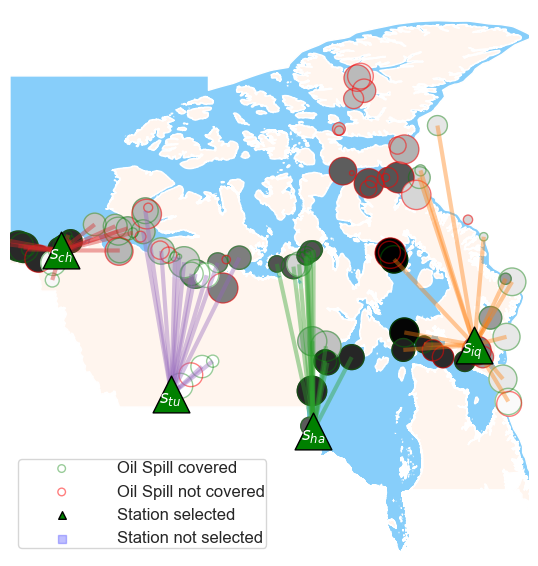

,Spill #,Station no.,St_Latitude,St_Longitude,Spill_Latitude,Spill_Longitude,Resource Type,Quantity deployed,Distance
0,o74,s300,63.742886,-68.464958,64.504219,-79.406021,c,31.0,10.967520
1,o98,s300,63.742886,-68.464958,73.858727,-77.062927,i,37.0,13.276118
2,o203,s300,63.742886,-68.464958,65.388885,-65.952179,c,5.0,3.003893
3,o7,s300,63.742886,-68.464958,70.286461,-67.008385,i,37.0,6.703729
4,o94,s300,63.742886,-68.464958,67.564018,-62.579475,i,7.0,7.017119
...,...,...,...,...,...,...,...,...,...
66,o181,s200,69.459000,-132.974304,70.016129,-131.524719,i,157.0,1.552961
67,o22,s200,69.459000,-132.974304,67.670395,-134.398529,i,157.0,2.286378
68,o187,s200,69.459000,-132.974304,69.537125,-133.217575,i,7.0,0.255508
69,o198,s200,69.459000,-132.974304,70.399017,-131.880280,c,5.0,1.442402


In [9]:
model_analysis.draw_network_diagram(DistanceMax, NumberStMax_m3, Sensitivity_R, spill_df_m3, station_df_m3, MeanResponseTime_m3, coverage_percentage_m3, assignment_m3, deploy_1s_m3, select_1s_m3, current_vs_proposed)

## Input & Output

In [68]:
input_output_df_m3 = pd.DataFrame(index=range(1),
                                  columns=['Max no of stations', 'Max distance (kms)','Coverage Percentage', 'Mean Response Time','Objective 1', 'Objective 2'])
input_output_df_m3.iloc[0,0] = NumberStMax_m3
input_output_df_m3.iloc[0,1] = DistanceMax
input_output_df_m3.iloc[0,2] = coverage_percentage_m3
input_output_df_m3.iloc[0,3] = MeanResponseTime_m3
input_output_df_m3.iloc[0,4] = objValues_m3[0::2][1]
input_output_df_m3.iloc[0,5] = objValues_m3[1::2][1]
input_output_df_m3

,Max no of stations,Max distance (kms),Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,4,10,83,10.59,963.915355,1.5


# Model Configuration 4 (Proposed 5 facility location)

## Input param

In [69]:
NumberStMax_m4a = 5
current_vs_proposed = 'proposed'
DistanceMax_m4a = 10

In [70]:
coordinates_potential_st = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_potential_st[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']
display(potential_st_coord)

,St_Latitude,St_Longitude
index,,
s1,70.000000,-134.000000
s2,70.639999,-119.430000
s3,67.089996,-112.320000
s4,62.599998,-113.190002
s5,60.529999,-114.379997
s6,68.860001,-103.190002
s7,63.930000,-101.139999
s8,60.060001,-95.889999
s9,75.110001,-95.709999


In [71]:
# Input param
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(potential_station_data, spill_data, input_parameters)

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20']


## Fig5(c) Network diagram m4a of proposed 5 facility

In [72]:
input_output_df_m4a = pd.DataFrame(index=range(1),
                                  columns=['Max no of stations', 'Max distance (kms)','Coverage Percentage', 'Mean Response Time','Objective 1', 'Objective 2'])
input_output_df_m4a.iloc[0,0] = NumberStMax_m4a
input_output_df_m4a.iloc[0,1] = DistanceMax_m4a
input_output_df_m4a.iloc[0,4] = coverage_percentage_m4a
input_output_df_m4a.iloc[0,5] = MeanResponseTime_m4a
input_output_df_m4a.iloc[0,2] = objValues_m4a[0::2][1]
input_output_df_m4a.iloc[0,3] = objValues_m4a[1::2][1]
input_output_df_m4a

,Max no of stations,Max distance (kms),Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,5,10,1127.227354,800.0,96,7.36


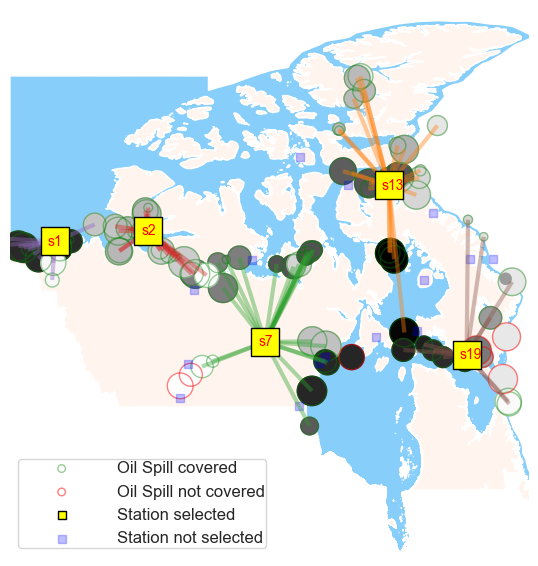

In [73]:
# Draw the network
assignment_line = model_analysis.draw_network_diagram(DistanceMax_m4a, NumberStMax_m4a, Sensitivity_R, spill_df_m4a, station_df_m4a, MeanResponseTime_m4a, coverage_percentage_m4a, assignment_m4a, deploy_1s_m4a, select_1s_m4a, current_vs_proposed)

# Model Configuration 4(b)

In [74]:
# Model
model_04a, select_m4a, deploy_m4a, mvars_m4a, names_m4a, values_m4a, objValues_m4a, \
        spill_df_m4a, station_df_m4a, cover_1s_m4a, select_1s_m4a, deploy_1s_m4a, MeanResponseTime_m4a, coverage_percentage_m4a, assignment_m4a  \
    = model.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m4a, Distance, Distance_n,
          W, QuantityMin, DistanceMax_m4a, Cf_s, CostU, Budget,
          BigM, MaxFO)

len of OilSpills:  100
--------------MIP-moo--------
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "Outputs/Logfiles/model_moo(Jul 14,0928).log"
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1832 rows, 1436 columns and 4534 nonzeros
Model fingerprint: 0x087a38c1
Variable types: 1062 continuous, 374 integer (374 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
-------------

## Input param

In [75]:
potential_station_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()

In [76]:
DistanceMax_4b = 10
NumberStMax_m4b = 5
current_vs_proposed = 'proposed'

In [77]:
coordinates_potential_st = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_potential_st[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']
display(potential_st_coord)

,St_Latitude,St_Longitude
index,,
s1,70.000000,-134.000000
s2,70.639999,-119.430000
s3,67.089996,-112.320000
s4,62.599998,-113.190002
s5,60.529999,-114.379997
s6,68.860001,-103.190002
s7,63.930000,-101.139999
s8,60.060001,-95.889999
s9,75.110001,-95.709999


In [78]:
# Input param
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(potential_station_data, spill_data, input_parameters)

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20']


In [79]:
# Model
model_04b, select_m4b, deploy_m4b, mvars_m4b, names_m4b, values_m4b, objValues_m4b, \
        spill_df_m4b, station_df_m4b, cover_1s_m4b, select_1s_m4b, deploy_1s_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b  \
    = model.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m4b, Distance, Distance_n,
          W, QuantityMin, DistanceMax_4b, Cf_s, CostU, Budget,
          BigM, MaxFO)

len of OilSpills:  100
--------------MIP-moo--------
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "Outputs/Logfiles/model_moo(Jul 14,0928).log"
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1832 rows, 1436 columns and 4534 nonzeros
Model fingerprint: 0x087a38c1
Variable types: 1062 continuous, 374 integer (374 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
-------------

## Fig8(b) Network diagram of proposed 5 facility

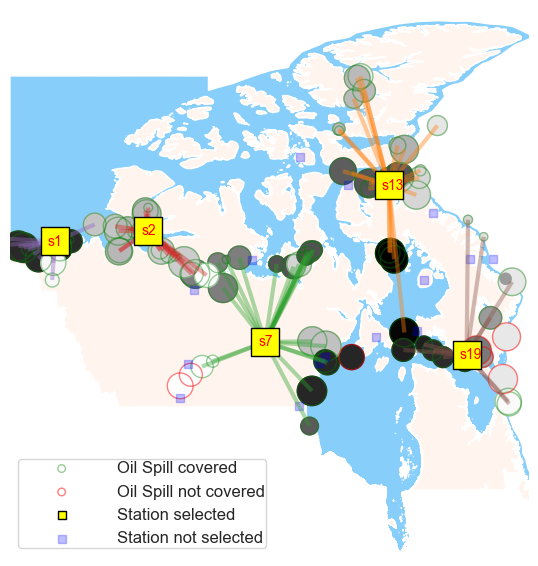

In [80]:
# Draw the network
assignment_line_m4b = model_analysis.draw_network_diagram(DistanceMax_4b, NumberStMax_m4b, Sensitivity_R, spill_df_m4b, station_df_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b, deploy_1s_m4b, select_1s_m4b, current_vs_proposed)

In [81]:
assignment_m4b

,Spill #,Station no.,St_Latitude,St_Longitude,Spill_Latitude,Spill_Longitude,Resource Type,Quantity deployed,Distance
0,o74,s13,73.400002,-81.830002,64.504219,-79.406021,m,20.0,9.220121
1,o98,s13,73.400002,-81.830002,73.858727,-77.062927,c,31.0,4.789095
2,o127,s13,73.400002,-81.830002,69.348618,-81.734749,i,7.0,4.052504
3,o51,s13,73.400002,-81.830002,73.861763,-82.001617,c,31.0,0.492621
4,o119,s13,73.400002,-81.830002,76.695244,-89.592224,c,110.0,8.432717
...,...,...,...,...,...,...,...,...,...
89,o22,s1,70.000000,-134.000000,67.670395,-134.398529,c,110.0,2.363448
90,o187,s1,70.000000,-134.000000,69.537125,-133.217575,i,7.0,0.909089
91,o198,s1,70.000000,-134.000000,70.399017,-131.880280,m,2.0,2.156949
92,o220,s1,70.000000,-134.000000,69.243050,-137.326294,m,20.0,3.411335


## I&O

In [82]:
input_output_df_m4b = pd.DataFrame(index=range(1), columns=['Max no of stations', 'Max distance (kms)', 'Coverage Percentage', 'Mean Response Time','Objective 1', 'Objective 2'])
input_output_df_m4b.iloc[0,0] = NumberStMax_m4b
input_output_df_m4b.iloc[0,1] = DistanceMax_4b
input_output_df_m4b.iloc[0,2] = coverage_percentage_m4b
input_output_df_m4b.iloc[0,3] = MeanResponseTime_m4b
input_output_df_m4b.iloc[0,4] = objValues_m4b[0::2][1]
input_output_df_m4b.iloc[0,5] = objValues_m4b[1::2][1]
input_output_df_m4b

,Max no of stations,Max distance (kms),Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,5,10,96,7.36,1127.227354,800.0


In [83]:
input_output_df_m4b

,Max no of stations,Max distance (kms),Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,5,10,96,7.36,1127.227354,800.0


# Compare Model 3 & 4b

In [84]:
assignment_line_m3 = pd.DataFrame(columns=list(assignment_m3.columns.values))
for i, o in enumerate(assignment_m3['Spill #'].unique()):
    minD = min(assignment_m3.loc[assignment_m3['Spill #'] == o]['Distance'])
    df = assignment_m3.iloc[np.where(assignment_m3['Distance'] == minD)[0]]
    assignment_line_m3 = pd.concat([assignment_line_m3, df])

resource_allocation_m3 = assignment_line_m3[['Station no.', 'Resource Type', 'Quantity deployed']]
resource_allocation_m3 = resource_allocation_m3.sort_values(by=['Station no.'])
resource_allocation_m3 = resource_allocation_m3.groupby(['Station no.', 'Resource Type'])['Quantity deployed'].mean().reset_index()
resource_allocation_m3['Facility'] = 'Current'
resource_allocation_m3

,Station no.,Resource Type,Quantity deployed,Facility
0,s200,c,33.800000,Current
1,s200,i,67.000000,Current
2,s300,c,18.000000,Current
3,s300,i,67.000000,Current
4,s6,c,57.500000,Current
5,s6,i,55.750000,Current
6,s9,c,57.428571,Current
7,s9,i,17.000000,Current
8,s9,m,32.400000,Current


In [85]:

for i, o in enumerate(assignment_m4b['Spill #'].unique()):
    minD = min(assignment_m4b.loc[assignment_m4b['Spill #'] == o]['Distance'])
    df = assignment_m4b.iloc[np.where(assignment_m4b['Distance'] == minD)[0]]
    assignment_line_m4 = pd.concat([assignment_line_m4b, df])

resource_allocation_m4b = assignment_line_m4b[['Station no.', 'Resource Type', 'Quantity deployed']]
resource_allocation_m4b = resource_allocation_m4b.sort_values(by=['Station no.'])
resource_allocation_m4b = resource_allocation_m4b.groupby(['Station no.', 'Resource Type'])['Quantity deployed'].mean().reset_index()
resource_allocation_m4b['Facility'] = 'Proposed'
resource_allocation_m4b

,Station no.,Resource Type,Quantity deployed,Facility
0,s1,c,78.400000,Proposed
1,s1,i,13.000000,Proposed
2,s1,m,40.666667,Proposed
3,s13,c,51.555556,Proposed
4,s13,i,61.000000,Proposed
5,s13,m,28.800000,Proposed
6,s19,c,46.142857,Proposed
7,s19,i,67.000000,Proposed
8,s2,c,44.250000,Proposed
9,s2,i,58.428571,Proposed


## Fig7a barplot - quantity stockplie
Produced in Excel file +++

In [86]:
resource_allocation = pd.concat([resource_allocation_m3, resource_allocation_m4b])
resource_allocation

,Station no.,Resource Type,Quantity deployed,Facility
0,s200,c,33.800000,Current
1,s200,i,67.000000,Current
2,s300,c,18.000000,Current
3,s300,i,67.000000,Current
4,s6,c,57.500000,Current
5,s6,i,55.750000,Current
6,s9,c,57.428571,Current
7,s9,i,17.000000,Current
8,s9,m,32.400000,Current
0,s1,c,78.400000,Proposed


<BarContainer object of 23 artists>

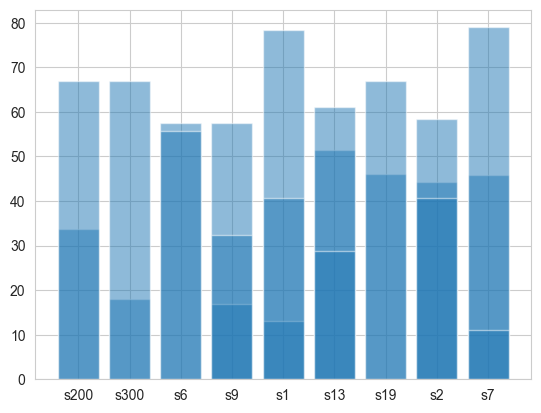

In [87]:
plt.bar(data=resource_allocation,
        x="Station no.", height="Quantity deployed",
        alpha = 0.5,
        )
#plt.legend(loc='upper right')

In [88]:
resource_allocation.to_excel('Outputs/resource_allocation_model3_vs_model4b.xlsx')

# Model Configuration 5 (Proposed 6 facility location)

## Data

In [89]:
NumberStMax_m5 = 6

In [90]:
potential_station_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()

In [91]:
current_vs_proposed = 'proposed'

In [92]:
coordinates_potential_st = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_potential_st[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']
display(potential_st_coord)
# Input param
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(potential_station_data, spill_data, input_parameters)

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))


,St_Latitude,St_Longitude
index,,
s1,70.000000,-134.000000
s2,70.639999,-119.430000
s3,67.089996,-112.320000
s4,62.599998,-113.190002
s5,60.529999,-114.379997
s6,68.860001,-103.190002
s7,63.930000,-101.139999
s8,60.060001,-95.889999
s9,75.110001,-95.709999


['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20']


## Run Model 5

In [93]:
DistanceMax_m5 = 10

In [94]:
# Model
model_05, select_m5, deploy_m5, mvars_m5, names_m5, values_m5, objValues_m5, \
        spill_df_m5, station_df_m5, cover_1s_m5, select_1s_m5, deploy_1s_m5, MeanResponseTime_m5, coverage_percentage_m5, assignment_m5  \
    = model.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m5, Distance, Distance_n,
          W, QuantityMin, DistanceMax_m5, Cf_s, CostU, Budget,
          BigM, MaxFO)

len of OilSpills:  100
--------------MIP-moo--------
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "Outputs/Logfiles/model_moo(Jul 14,0929).log"
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1832 rows, 1436 columns and 4534 nonzeros
Model fingerprint: 0x2e4ba32f
Variable types: 1062 continuous, 374 integer (374 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
-------------

## Network diagram of proposed 6 facility

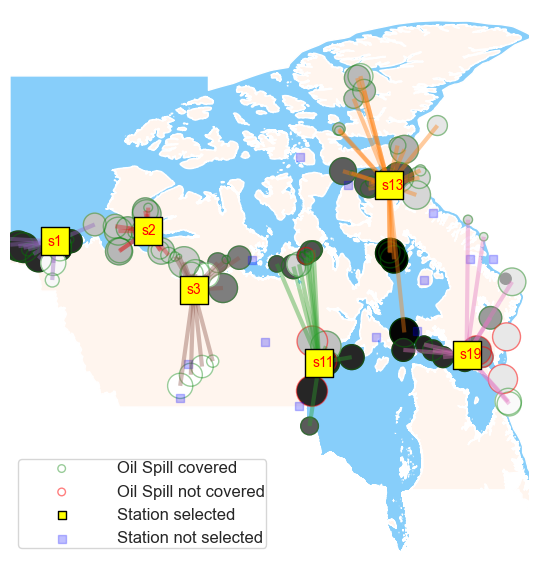

In [95]:
# Draw the network
assignment_line_m5 = model_analysis.draw_network_diagram(DistanceMax_m5, NumberStMax_m5, Sensitivity_R, spill_df_m5, station_df_m5, MeanResponseTime_m5, coverage_percentage_m5, assignment_m5, deploy_1s_m5, select_1s_m5, current_vs_proposed)

## I&O

In [96]:
input_output_df_m5 = pd.DataFrame(index=range(1), columns=['Max no of stations', 'Max distance', 'Coverage Percentage', 'Mean Response Time','Objective 1', 'Objective 2'])
input_output_df_m5.iloc[0,0] = NumberStMax_m5
input_output_df_m5.iloc[0,1] = DistanceMax_m5
input_output_df_m5.iloc[0,2] = coverage_percentage_m5
input_output_df_m5.iloc[0,3] = MeanResponseTime_m5
input_output_df_m5.iloc[0,4] = objValues_m5[0::2][1]
input_output_df_m5.iloc[0,5] = objValues_m5[1::2][1]
input_output_df_m5

,Max no of stations,Max distance,Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,6,10,99,6.64,1149.128698,-4249.835139
